In [1]:
# !nvidia-smi

In [2]:
# !pip install -q git+git://github.com/fastai/fastcore.git
# !pip install -q git+git://github.com/fastai/fastai2.git
# !pip install -q git+git://github.com/lgvaz/faststyle.git@weights

In [3]:
from fastai2.vision.all import *
from faststyle import *

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  root_dir = Path('/content/gdrive/My Drive/dl')
except ImportError:
  root_dir = Path.home()/'dl'
root_dir.mkdir(exist_ok=True)

In [5]:
source = untar_data(URLs.COCO_SAMPLE)

In [6]:
fns = get_image_files(source)

In [7]:
mname = 'stl_weights448.pkl'
learn = load_learner(root_dir/f'faststyle/exports/{mname}')

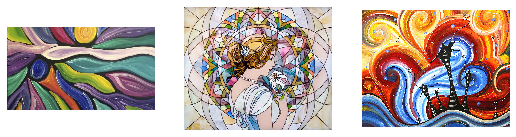

In [8]:
style_dir = Path('styles')
style_fns = L('abstract.jpg', 'mosaic.jpg', 'village.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [9]:
def get_items(path, n=3):
  fns = get_image_files(source)
  return fns.map(lambda o: [o, random_weights(n)])

In [10]:
fns_pairs = get_items(source)
dset = Datasets(fns_pairs, splits=RandomSplitter()(fns),
                tfms=[[ImageWeight.create], [itemgetter(0), PILImage.create]])

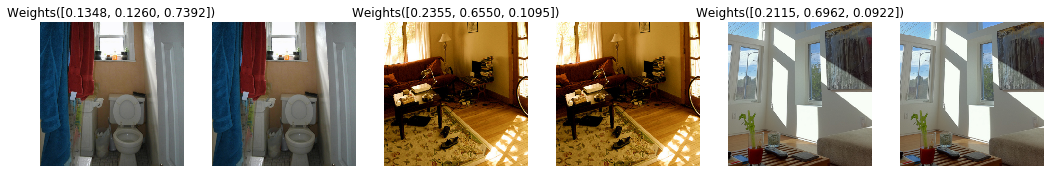

In [11]:
dls = dset.dataloaders(bs=10,
                       after_item=[ToTensor(), Resize(512), RandomizeWeights],
                       after_batch=[IntToFloatTensor, NormalizeX.from_stats(*coco_stats), *aug_transforms(size=448)])
dls.show_batch(max_n=3)

In [12]:
layer_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [13]:
loss_func = FastStyleLoss(stl_w=1e5, tv_w=300)
cbs = [FeatsCallback.from_fns(style_fns, layer_feats), WeightsCallback()]
learn = Learner(dls, TransformerNet2(3), loss_func, cbs=cbs, metrics=loss_func.metrics)
learn.path = root_dir/'faststyle'; learn.path.mkdir(exist_ok=True)

In [21]:
learn.fit_one_cycle(1, 1e-4, pct_start=.2)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,19.276836,19.385145,5.440065,9.359710,4.585379,1:01:45


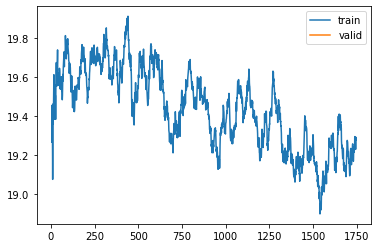

In [22]:
learn.recorder.plot_loss()

In [0]:
learn.save('stl_weights448_2') 

In [12]:
mname = 'stl_weights448.pkl'
learn = load_learner(root_dir/f'faststyle/exports/{mname}')

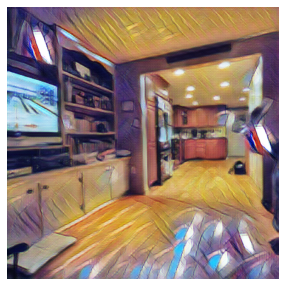

In [27]:
pred,_,_=learn.predict([fns[5], [.98, .01, .01]])
pred.show()

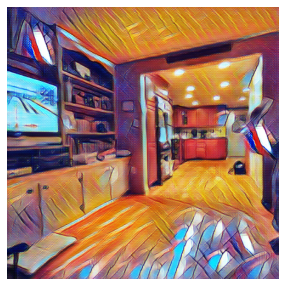

In [30]:
pred,_,_=learn.predict([fns[5], [.01, .01, .98]])
pred.show()

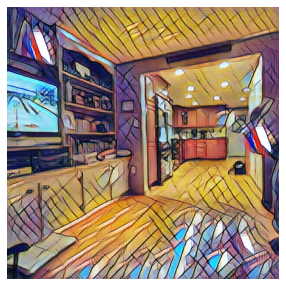

In [31]:
pred,_,_=learn.predict([fns[5], [.01, .98, .01]])
pred.show()

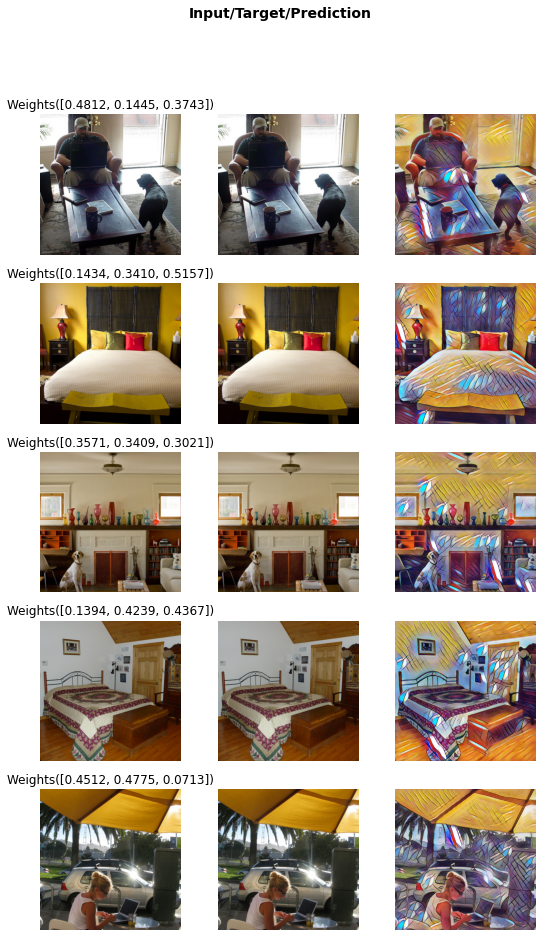

In [32]:
learn.show_results()

In [15]:
export_dir = learn.path/'exports'; export_dir.mkdir(exist_ok=True)
learn.export(export_dir/'stl_weights448.pkl')